Your name: //IGNORE

Your student ID number: //IGNORE

Shared link to this notebook: //IGNORE

# Programming Assignment 2 (P2) for COMPSCI 446, Search Engines

_This is an updated version of the notebook for P2. Please watch Piazza for announcements of new versions and/or check back periodically to see if it has been updated._

_As of this version of the notebook, the autograder is set up in Gradescope._


The purpose of this project is to explore and implement some of the effectiveness measures discussed in class and in the text (Section 8.4). You will implement a function called eval that will be invoked as follows:
```python
eval(trecrunFile, qrelsFile, outputFile)
```

where `trecrunFile` and `qrelsFile` are files that we will provide to you and `outputFile` is where you will print the evaluation results of the trecrun file.

A trecrun file contains the actual system runs that you are going to evaluate. It is a text file with six space-separated columns on every line (note that for obvious reasons, no column can contain spaces):
- The first column is the query name (aka query id)
- The second column is unused and should always contain "skip" (for historical reasons)
- The third column is a document identifier (“docid”)
- The fourth column is the rank of that document for that query in this run
- The fifth column is the score from the retrieval model.
- The sixth column is some text to describe the run itself, normally the same for every line in the file.

The qrels file contains judgment information: given a query and a document, is the document relevant to the query? It is another space-separated text file:
- The first column is the query name/id (corresponding to the query name/id in the trecrun files)
- The second column is unused (it is present for historical reasons; you won't need to do anything with it except be sure you read it to get to the remaining columns)
- The third column is a document identifier (“docid”)
- The fourth column is a number representing the relevance of the document, either 0 for non-relevant, or positive for relevant.

We will provide a common qrels file as well as several trecrun files and sample output files. We will also provide copies of the queries in case you find it useful, though they aren't needed.

Note that for many of the query-docid pairs in the trecrun file, you will find a corresponding pair in the qrels file, helping you to evaluate how well the retrieval model did for that query. However, as discussed in class, **large numbers of query-docid pairs will be unjudged, so will not appear in the qrels file. When you encounter that, you should assume that the query-docid pair is non-relevant** (i.e., has a relevance score of zero).

Your code will read in the provided trecrun and qrels files. It will then generate evaluation scores and print them in a particular format (see below) to the indicated output filename.




# 0. Setup

In [1]:
version = 2 # DO NOT MODIFY. If notebook does not match with autograder version, many tests are likely to fail!!



We first execute the following to connect to Google Drive (you will be prompted repeatedly for access to your Google Drive; please give it permission) and download copies of the sample files listed above. You should not need to make any modifications to the code, though if you want to use a slightly different path in Google Drive, you can modify the appropriate data_path value. (The autograder will not use your Google Drive.)

In [8]:
import os
import string
import gzip
import re

import math
import sys
from collections import defaultdict

try:
    from google.colab import drive
    in_colab = True
except ImportError:
    in_colab = False


# You are more than welcome to code some helper functions.
# But do note that we are only grading functions that are coded in the template files.


# Connect to Google Drive and download copies of the sample files listed above.
# Please allow the access to your Google Drive or the following dataset loader will fail.
# (The autograder will not use your Google Drive.)
if in_colab:
  drive.mount("/content/drive/") ## DO NOT MODIFY THIS LINE
  data_path = "/content/drive/MyDrive/COMPSCI446" ## CREATE THIS FOLDER/DIRECTORY IN YOUR GOOGLE DRIVE
else:
  data_path = "./data/"  ## DO NOT MODIFY THIS LINE. CHANGING THIS LINE WOULD RESULT IN FAIL OF AUTOGRADER TESTS

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will now download the files needed for this assignment to your Google Drive in the path declared in <em>data_path</em> so that you can work with them in the rest of the notebook. We will not bother loading the files if they have already been loaded to your Google Drive, so this should be a one-time effort.

**NOTE**: This code will not create a new folder for you. It assumes that you have a folder called COMPSCI446 at the top level of your Google Drive. You can create that folder and everything will work fine. If you want to create something different (e.g., COMPSCI446-P2 or COMPSCI446/P2) then create that folder and edit the data_path line in the cell above.

In [10]:
import urllib.request
from pathlib import Path
import zipfile

def download_file(file_path: str, zip: bool = True) -> None:
    """
    Download the file to proper location in mounted Google Drive.

    Args:
        file_path: the location of file we want to download

    """

    webloc = "https://cs.umass.edu/~allan/cs446/"


    data_info = Path(data_path)
    if not data_info.exists() or not data_info.is_dir():
      print(f"Google folder \"{data_path}\" is not present or not a folder. Can't download file {file_path}.")
      return

    local_google_drive_path = os.path.join(data_path,file_path)
    local_file = Path(local_google_drive_path)
    if local_file.is_file():
        print(f"File \"{file_path}\" already exists, not downloading.")
    else:
        print(f"Cannot find \"{file_path}\" so downloading it.")
        urllib.request.urlretrieve(webloc + file_path, local_google_drive_path)
        print("Done")

    if zip:
      with zipfile.ZipFile(local_google_drive_path, 'r') as zip_ref:
        print(f"Unzipping \"{file_path}\"")
        zip_ref.extractall(data_path)



P2_train_path = "P2train.zip"
P2_output = "P2train-output.zip"

download_file(P2_train_path)
download_file(P2_output)

Cannot find "P2train.zip" so downloading it.
Done
Unzipping "P2train.zip"
Cannot find "P2train-output.zip" so downloading it.
Done
Unzipping "P2train-output.zip"


In this assignment, we're testing only the end result of your program -- i.e., the output file -- after it runs, parses, and evaluates the `trecrun` and `qrels` file correctly. Therefore, the only function that you **MUST** have is the eval function:
```python
def eval(trecrunFile, qrelsFile, outputFile):
  pass
```
Other than providing a functional eval() function, **you are free to define supporting functions, classes, and use standard python libraries to implement the `eval` function in any way that you like**.

**However**, we know that different people have different code structures in mind, but for ease of debugging and readability purposes, we suggest you follow the provided general outline below for your program. If you prefer another way to structure the program, you can go ahead and replace the outline with yours. As mentioned, the only exception is the `eval` function where you have to make sure that you don't modify the definition at the bottom of this notebook or the expected format of the inputs/outputs (or else the autograder will fail and your grade will suffer).

# 1. Loading the data

## 1.1 Creating a data structure

The qrels and trecrun files can get very large. Iterating through the entire file for each run will take minutes, if not longer, and therefore is impractical. In practice, it is more efficient to implement a data structure to hold `qrels` and  `trecrun` information.

We'll highlight once more that this is a suggested way to handle the qrels and trecrun files. You _unquestionably_ want to store them in some data struture, but what you call it and how you use it is entirely up to you. We're providing a suggestion that may help you.

In [34]:
class QueryInfo:
  """
  QueryInfo class: store the trecrun and qrels data of each query
  """

  #########
  ##
  ## Add any attributes and methods necessary
  ##
  #########


  def __init__(self):
    self.trecrun = []  # List to store trecrun data (rankings for each document)
    self.qrels = {}
    self.ranked_list = []   # Dictionary to store qrels data (docid: relevance score)

For easier access to qrel and trecrun information during evaluation measure calculations, we suggest you store all query information in a dictonary mapping query ids to the corresponding query object. Note that this example assumes that query ids are strings (rather than integers) which is a good assumption.

In [12]:
queries = dict[str, QueryInfo]() # dictionary to store query_id/QueryInfo mappings

## 1.2 Parsing trecruns
Now we can use the data structure above to store the trecrun rankings:

In [35]:
def read_trecrun(trecRunFile: str, queriesDict: dict[str, QueryInfo]) -> None:
  """
  Read the trecrun file data and store the ranking lists for each query in a corresponding QueryInfo object.

  Args:
        trecRunFile: path to where the trecrun file is stored
        queriesDict: dictionary to store QueryInfos, mapping each query's id to its corresponding QueryInfo object
  """

  #########
  ##
  ## Implement the function here
  ##
  #########

  with open(trecRunFile, 'r') as file:
    for line in file:
        query_id, _, docid, rank, score, run_name = line.strip().split()
        if query_id not in queriesDict:
            queriesDict[query_id] = QueryInfo()
        queriesDict[query_id].trecrun.append({
            'docid': docid,
            'rank': int(rank),
            'score': float(score),
            'run_name': run_name
        })
        queriesDict[query_id].ranked_list.append(docid)  # Populate ranked_list


##1.3 Parsing qrels
Add the qrels data to the data structure as well:

In [14]:
def read_qrels(qrelsFile: str, queriesDict: dict[str, QueryInfo]) -> None:
  """
  Read the qrels file data and store the relevance judgements for each query in a corresponding QueryInfo object.

  Args:
        qrelsFile: path to where the qrels file is stored
        queriesDict: dictionary to store QueryInfos, mapping each query's id to its corresponding QueryInfo object
  """

  #########
  ##
  ## Implement the function here
  ##
  #########

  with open(qrelsFile, 'r') as file:
    for line in file:
        query_id, _, docid, relevance = line.strip().split()
        if query_id not in queriesDict:
            queriesDict[query_id] = QueryInfo()
        queriesDict[query_id].qrels[docid] = int(relevance)

# 2. Effectiveness measures

We expect you to implement the following effectiveness measures and later (in the ```eval``` function) report values on them for any trecrun file that is provided. **If the file contains multiple queries (which it usually will), you will need to calculate measures for each query and then also produce the arithmetic mean of each evaluation measure across all queries in the trecrun file.**

Note that you are producing these numbers for every query that occurs in the trecrun file. There will probably be queries listed in the qrels file that are not in the trecrun file; ignore them.

The measures you will need to implement for each query are (please use the formulations described in the textbook, and macro-averaging where given the choice):

- `numRel` is the total number of relevant documents (relevance score above zero) that are listed in the qrels file for this query.
- `relFound` is the count of those relevant documents that also appear in the ranked list of documents.
- `RR` (Reciprocal Rank); if relFound is zero, then report “0” for this measure.
- `P@13` (Precision @ 13)
- `R@13` (Recall @ 13); if numRel is zero, then report "0" for this measure.
- `F1@13`; if either precision or recall is zero, then report "0" for this measure.
- `AP` (Average Precision); if numRel is zero, report "0".
- `nDCG@23` (there are multi-value relevance judgments in the data – 0,1,2 – though some queries only have 0/1 judgments). If numRel is zero, then report 0 for nDCG. Hint: A key thing to note in calculating nDCG is that the "ideal" DCG cannot be calculated using just the retrieved documents for a given query. Think about why so you avoid that mistake (it was a midterm question, too). Note: use the DCG equation on page 319 of the textbook that just uses $rel_i$, not the equation that is in footnote 10 of page 320 that uses $2^{rel_i}-1$.
- `BPREF`. If numRel is zero, report "0". Use the formula $\frac{1}{R}\Sigma_{d_r}(1-\frac{N_{d_r}}{R})$.


*Extra Credit:*

- `P@29R` is precision when recall is 29 percent (note that this is percent recall and not rank 29); if numRel is zero, report "0". Remember that this requires that you interpolate to figure out the precision -- it is the maximum precision at any recall value $R'$ where $R' \geq R$. See section 8.4.2 in the textbook or the content of the evaluation lecture.
- `P@R` where $R$ is the number of relevant documents for this query; if numRel is zero, report "0".

For the extra credit items, we are not providing sample output and when you submit your assignment, you will only be told that the autograder _found_ your extra credit (or not). As a hint, though, in the BM25 run of msmarcosmall, for query 390360 you should find that P@29R is 0.4400 and that P@R is 0.3429. And for query 118440, you should get 0.0000 and 0.0461, respectively.

The following are possible stubs for the evaluation functions. One last time, note that you are not required to implement them this way, but you may find this way of thinking about it helpful.

These stubs assume that you have identified the "query info" for the query you're considering and that you pass that in. The suggested variable ```queries``` was defined earlier as a dictionary that mapped query ids to this query information.

In [17]:
def numRel(query: QueryInfo) -> int:
    """
    Calculate total number of relevant documents that are listed in the qrels file for the given query.

    Args:
        query: input query holding the qrels and ranked list information

    Returns: number of relevant documents in the corpus for this query
    """
    # Count documents in qrels with a relevance score greater than 0
    return sum(1 for relevance in query.qrels.values() if relevance > 0)


In [18]:
def relFound(query: QueryInfo) -> int:
    """
    Calculate the number of relevant documents retrieved in the ranked list for the given query.

    Args:
        query: input query holding the qrels and ranked list information

    Returns: number of relevant documents retrieved in the ranked list for this query
    """
    # Count documents in the ranked list that are relevant (relevance score > 0 in qrels)
    return sum(1 for docID in query.ranked_list if query.qrels.get(docID, 0) > 0)


In [19]:
def RR(query: QueryInfo) -> float:
    """
    Calculate the reciprocal rank for the given query.

    Args:
        query: input query holding the qrels and ranked list information

    Returns: single number representing the reciprocal rank score of this query
    """
    # Iterate through the ranked list and find the first relevant document
    for rank, docID in enumerate(query.ranked_list, start=1):
        if query.qrels.get(docID, 0) > 0:  # Relevance > 0 means the document is relevant
            return 1.0 / rank
    return 0.0  # If no relevant document is found, return 0


In [20]:
def P_13(query: QueryInfo) -> float:
    """
    Calculate Precision at 13 for the given query.

    Args:
        query: input query holding the qrels and ranked list information

    Returns: single number representing the P@13 score of this query
    """
    # Take the top 13 documents from the ranked list
    top_13 = query.ranked_list[:13]
    # Count the relevant documents within the top 13
    relevant_count = sum(1 for docID in top_13 if query.qrels.get(docID, 0) > 0)
    # Precision is the fraction of relevant documents out of the total 13 (or fewer if fewer documents are present)
    return relevant_count / len(top_13) if top_13 else 0.0


In [21]:
def R_13(query: QueryInfo) -> float:
    """
    Calculate Recall at 13 for the given query.

    Args:
        query: input query holding the qrels and ranked list information

    Returns: single number representing the R@13 score of this query
    """
    # Total number of relevant documents for the query
    total_relevant = numRel(query)
    if total_relevant == 0:
        return 0.0  # Avoid division by zero, recall is 0 if no relevant documents exist

    # Take the top 13 documents from the ranked list
    top_13 = query.ranked_list[:13]
    # Count the relevant documents within the top 13
    relevant_in_top_13 = sum(1 for docID in top_13 if query.qrels.get(docID, 0) > 0)

    # Recall is the fraction of relevant documents in the top 13 out of all relevant documents
    return relevant_in_top_13 / total_relevant


In [22]:
def F1_13(query: QueryInfo) -> float:
    """
    Calculate F1 score at 13 for the given query.

    Args:
        query: input query holding the qrels and ranked list information

    Returns: single number representing the F1@13 score of this query
    """
    # Calculate Precision at 13
    precision = P_13(query)
    # Calculate Recall at 13
    recall = R_13(query)

    # Avoid division by zero: F1 is 0 if either precision or recall is 0
    if precision == 0 or recall == 0:
        return 0.0

    # F1 Score formula: 2 * (precision * recall) / (precision + recall)
    return 2 * (precision * recall) / (precision + recall)


In [23]:
def AP(query: QueryInfo) -> float:
    """
    Calculate Average Precision for the given query.

    Args:
        query: input query holding the qrels and ranked list information

    Returns: single number representing the average precision score of this query
    """
    # Extract relevant data from the query object
    ranked_list = query.ranked_list  # Assuming this holds the ranked list of document IDs
    qrels = query.qrels  # Assuming this holds the relevance judgments for the query

    num_rel = sum(1 for doc in qrels if qrels[doc] > 0)  # Total number of relevant documents
    if num_rel == 0:  # No relevant documents, AP is 0
        return 0.0

    sum_precision = 0.0  # Sum of precisions at ranks with relevant documents
    num_relevant_found = 0  # Counter for relevant documents found in the ranked list

    for rank, doc_id in enumerate(ranked_list, start=1):
        if doc_id in qrels and qrels[doc_id] > 0:  # Check if the document is relevant
            num_relevant_found += 1
            precision_at_k = num_relevant_found / rank
            sum_precision += precision_at_k

    return sum_precision / num_rel  # Average precision


In [24]:
def NDCG_23(query: QueryInfo) -> float:
    """
    Calculate nDCG at 23 for the given query.

    Args:
          query: input query holding the qrels and ranked list information

    Returns: single number representing the nDCG at 23 score of this query
    """
    ranked_list = query.ranked_list[:23]  # Limit to top 23 documents
    qrels = query.qrels  # Relevance judgments

    def dcg(relevance_scores):
        return sum(
            (2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(relevance_scores)
        )

    relevance_scores = [qrels.get(doc_id, 0) for doc_id in ranked_list]
    ideal_relevance_scores = sorted(
        (score for score in qrels.values() if score > 0), reverse=True
    )[:23]

    dcg_val = dcg(relevance_scores)
    idcg_val = dcg(ideal_relevance_scores)

    return dcg_val / idcg_val if idcg_val > 0 else 0.0


In [25]:
def BPREF(query: QueryInfo) -> float:
    """
    Calculate BPREF for the given query.

    Args:
          query: input query holding the qrels and ranked list information

    Returns: single number representing the BPREF score of this query
    """
    ranked_list = query.ranked_list  # Ranked list of document IDs
    qrels = query.qrels  # Relevance judgments

    relevant_docs = [doc for doc, rel in qrels.items() if rel > 0]
    non_relevant_docs = [doc for doc, rel in qrels.items() if rel == 0]

    num_rel = len(relevant_docs)
    if num_rel == 0:
        return 0.0

    num_non_rel = len(non_relevant_docs)
    sum_score = 0.0

    for idx, doc_id in enumerate(ranked_list):
        if doc_id in relevant_docs:
            non_rel_seen = sum(
                1 for prev_doc in ranked_list[:idx] if prev_doc in non_relevant_docs
            )
            sum_score += 1 - (non_rel_seen / min(num_rel, num_non_rel))

    return sum_score / num_rel


These next two stubs are for the optional extra credit.

In [26]:
def P_29R(query: QueryInfo) -> float:
    """
    (Extra Credit) Calculate Precision at 29% recall for the given query.

    Args:
          query: input query holding the qrels and ranked list information

    Returns: single number representing the Precision at 29% recall score of this query
    """
    ranked_list = query.ranked_list  # Ranked list of document IDs
    qrels = query.qrels  # Relevance judgments

    relevant_docs = [doc for doc, rel in qrels.items() if rel > 0]
    num_rel = len(relevant_docs)

    if num_rel == 0:
        return 0.0

    target_recall_count = math.ceil(0.29 * num_rel)
    relevant_found = 0
    precision_at_29r = 0.0

    for rank, doc_id in enumerate(ranked_list, start=1):
        if doc_id in relevant_docs:
            relevant_found += 1
            if relevant_found == target_recall_count:
                precision_at_29r = relevant_found / rank
                break

    return precision_at_29r


In [27]:
def PatR(query: QueryInfo) -> float:
    """
    (Extra Credit) Calculate Precision at the number of relevant documents for the given query.

    Args:
          query: input query holding the qrels and ranked list information

    Returns: single number representing the Precision at R score of this query
    """
    ranked_list = query.ranked_list  # Ranked list of document IDs
    qrels = query.qrels  # Relevance judgments

    relevant_docs = [doc for doc, rel in qrels.items() if rel > 0]
    num_rel = len(relevant_docs)

    if num_rel == 0:
        return 0.0

    relevant_found = 0
    for rank, doc_id in enumerate(ranked_list, start=1):
        if doc_id in relevant_docs:
            relevant_found += 1
        if relevant_found == num_rel:
            return relevant_found / rank

    return 0.0


# 3. Evaluation and Output

For each input trecrun file, we want you to report the calculated measures in the output file following the format given below. If the trecrun file contains multiple queries, you will need to calculate and report measures for each query. At the end of the evaluation output file, you should also include the _sum_ of the values for numRel and relFound, but the (arithmetic) _mean_ value of each of the other measures, averaged (or summed) across all queries in the trecrun file. In each case you will calculate scores per query and the mean or summed scores (so, for example, you will calculate AP for each query and the mean AP -- i.e., MAP -- for each TREC run overall). Your output format for each query should be exactly as follows, except that the amount of whitespace you use to separate fields is your choice. Each line will look like:
```
measure    queryid    score
```
Where measure is one of those given above. For most measures, format the scores to include exactly four digits after the decimal place. For counts, just report the integer number. For example, for query 302 you might get (these numbers are random, so not meaningful; plus the last two are extra credit, so you might not have them):
```

numRel        302    23
relFound      302    20
RR            302    1.0000
P@13          302    0.6667
R@13          302    0.1846
F1@13         302    0.2667
NDCG@23       302    0.3118
AP            302    0.1531
BPREF         302    0.3333
P@29R         302    0.5000
P@R           302    0.1111
```
For the final average across queries, replace RR with MRR and AP with MAP since those are the normal names for the means. Also, for the final averages, use "all" in place of the queryname. For example,
```
MRR           all   0.9438
MAP           all   0.0581
```

In [29]:
def report_measures(outputFile: str, results) -> None:
    """
    Write all calculated measures into the output file.

    Args:
          outputFile: path in which the output file should be stored
          results: contains all calculated measures for all queries in the trecrun file
    """
    with open(outputFile, "w") as f:
        for query_id, measures in results.items():
            for measure_name, score in measures.items():
                # Write each measure in the required format
                if isinstance(score, float):
                    f.write(f"{measure_name}\t{query_id}\t{score:.4f}\n")
                else:  # For integer measures like numRel, relFound
                    f.write(f"{measure_name}\t{query_id}\t{score}\n")

        # Write overall averages or totals using "all" as the query_id
        if "all" in results:
            for measure_name, score in results["all"].items():
                if isinstance(score, float):
                    f.write(f"{measure_name}\tall\t{score:.4f}\n")
                else:
                    f.write(f"{measure_name}\tall\t{score}\n")


## Putting it all together
Use all the definitions and functions you implemented above to complete the definition of the  `eval` function, regardless of whether you used our suggestions or structured things in your own way.

Remember that the expected behavior of the `eval` function is to take as input paths to trecrun and qrel files, calculate all the measures for each query in the trecrun file, and report the calculated measures and their averages in an output file in the path included in the input to `eval`.

Make sure not to modify the definition of the `eval` function or the expected format of the inputs/outputs (otherwise the autograder will fail). The body of the ``eval`` function will depend on how you implemented the details above.

In [40]:
def eval(trecrunFile: str, qrelsFile: str, outputFile: str) -> None:
    """
    Calculate and report all the measures for each query in the trecrun file.

    Args:
          trecRunFile: path to where the trecrun file is stored
          qrelsFile: path to where the qrels file is stored
          outputFile: path in which the output file should be stored
    """
    queries = {}  # Dictionary to store query_id -> QueryInfo mappings

    # Parse the trecrun and qrels files
    read_trecrun(trecrunFile, queries)
    read_qrels(qrelsFile, queries)

    results = {}

    # Calculate measures for each query
    for query_id, query_info in queries.items():
        measures = {}
        measures["numRel"] = numRel(query_info)
        measures["relFound"] = relFound(query_info)
        measures["RR"] = RR(query_info)
        measures["P@13"] = P_13(query_info)
        measures["R@13"] = R_13(query_info)
        measures["F1@13"] = F1_13(query_info)
        measures["AP"] = AP(query_info)
        measures["nDCG@23"] = NDCG_23(query_info)
        measures["BPREF"] = BPREF(query_info)
        # Optional extra credit measures
        measures["P@29R"] = P_29R(query_info)
        measures["P@R"] = PatR(query_info)
        results[query_id] = measures

    # Calculate averages and totals across all queries
    all_measures = {}
    total_queries = len(queries)
    all_measures["numRel"] = sum(results[q]["numRel"] for q in results)
    all_measures["relFound"] = sum(results[q]["relFound"] for q in results)
    all_measures["MRR"] = sum(results[q]["RR"] for q in results) / total_queries
    all_measures["MAP"] = sum(results[q]["AP"] for q in results) / total_queries
    all_measures["P@13"] = sum(results[q]["P@13"] for q in results) / total_queries
    all_measures["R@13"] = sum(results[q]["R@13"] for q in results) / total_queries
    all_measures["F1@13"] = sum(results[q]["F1@13"] for q in results) / total_queries
    all_measures["nDCG@23"] = sum(results[q]["nDCG@23"] for q in results) / total_queries
    all_measures["BPREF"] = sum(results[q]["BPREF"] for q in results) / total_queries

    # Optional extra credit averages
    all_measures["P@29R"] = sum(results[q]["P@29R"] for q in results) / total_queries
    all_measures["P@R"] = sum(results[q]["P@R"] for q in results) / total_queries

    results["all"] = all_measures

    # Write results to the output file
    report_measures(outputFile, results)


### Run the evaluation

Now we can run the evaluation on the trecruns provided. Here's a breakdown of all the files we previously downloaded for this assignment. First, the `P2train.zip` file contains:

- `msmarco.queries` is the actual queries that were used to generate the run files provided here and for which the qrels indicate what is relevant. You may find this useful or you may not. You do not need to use the file for the evaluation itself. It is provided in case you are curious.
- `msmarco.qrels` is the list of which documents are relevant to which queries in the format described earlier. This file should be used for all of your evaluations in this project. Note that some queries will appear in this file but may not be in the trecrun output. In that case your evaluation output should not list those queries.
- `msmarcosmall-{ql,bm25,dpr}.trecrun` are three ranked list files that you can use to try out your code.
- `msmarcofull-{ql,bm25,dpr}.trecrun` are three files that you will evaluate without having the output provided to you. It is a superset of `msmarcosmall-*.trecrun`, so you could check that you get the same answers on the queries that are copied over.

The file `P2train-output.zip` contains:
- `msmarcosmall-{ql,bm25,dpr}.expeval` are the three output files corresponding to `msmarcosmall*.trecrun` showing what the output for each of those should be.

Note that all of these files should have been successfully downloaded and unzipped in your `data_path` directory very early in this notebook.

In [41]:
import os

qrels_file = ""
trecrun_files = []
expected_output_files = []


for filename in os.listdir(data_path):
    if os.path.isfile(os.path.join(data_path, filename)):

        if filename.endswith('.qrels'):
          qrels_file = os.path.join(data_path, filename)
        if filename.endswith('.trecrun'):
          trecrun_files.append(os.path.join(data_path, filename))
        if filename.endswith('.expeval'):
          expected_output_files.append(os.path.join(data_path, filename))

        print(filename)

P2train.zip
msmarco.queries
msmarcofull-ql.trecrun
msmarcofull-dpr.trecrun
msmarcofull-bm25.trecrun
msmarcosmall-ql.trecrun
msmarcosmall-dpr.trecrun
msmarcosmall-bm25.trecrun
msmarco.qrels
P2train-output.zip
msmarcosmall-bm25.expeval
msmarcosmall-dpr.expeval
msmarcosmall-ql.expeval
msmarcofull-ql.eval
msmarcofull-dpr.eval
msmarcofull-bm25.eval
msmarcosmall-ql.eval
msmarcosmall-dpr.eval
msmarcosmall-bm25.eval


Next we can run the `eval` function for all trecrun files downloaded. (During debugging you may want to do just one of the files until things work.)

In [42]:
for trecrun_file in trecrun_files:
  run_name = os.path.splitext(trecrun_file)[0]
  output_file = run_name + '.eval'

  eval(trecrun_file, qrels_file, output_file)


You are encouraged to write additional code to test the output of your evaluation function and compare with the expected output files (or manually do so) before submitting to Gradescope. In particular, you might want to consider edge cases where something odd (but technically correct) is happening.

Note that generating the output files is to help you debug your overall evaluation processing. The autograder will regenerate all of the output files itself, including some on data that you do not have access to.

# 4. Analysis questions

## 4.1 Comparison table
Create a table of the "full" QL, BM25, and DPR runs where the table has six columns as follows:

* Column one is a query number
* Column two is that query's AP performance on BM25 (%6.4f)
* Column three is that query's AP for that query in QL (%6.4f)
* Column four is the percent improvement from BM25 to QL (%5.1f)
* Column five is the query's performance in DPR (%6.4f)
* Column six is the percent improvement from BM25 to DPR (%5.1f)

You can write whatever function you like to do this (we will grade the output and not test your function directly). It might be simplest to read in multiple trecrun files and evaluate them each to generate this information, most likely using your existing evaluation code.


In [44]:
import os

def comparison_table():
    """
    Create a comparison table for the "full" QL, BM25, and DPR runs.
    The table includes six columns:
      1. Query number
      2. AP for BM25
      3. AP for QL
      4. Percent improvement from BM25 to QL
      5. AP for DPR
      6. Percent improvement from BM25 to DPR
    """
    # Define the file paths for the full BM25, QL, and DPR trecrun files
    bm25_file = "/content/drive/MyDrive/COMPSCI446/msmarcofull-bm25.trecrun"
    ql_file = "/content/drive/MyDrive/COMPSCI446/msmarcofull-ql.trecrun"
    dpr_file = "/content/drive/MyDrive/COMPSCI446/msmarcofull-dpr.trecrun"
    qrels_file = "/content/drive/MyDrive/COMPSCI446/msmarco.qrels"

    # Temporary output file for evaluation results
    temp_output = "temp_output.eval"

    # Function to evaluate and parse the results
    def eval_file(file, qrels_file, output_file):
        if not os.path.exists(file):
            print(f"Error: File {file} does not exist.")
            return {}

        eval(file, qrels_file, output_file)  # Calling the eval function you provided

        if not os.path.exists(output_file) or os.path.getsize(output_file) == 0:
            print(f"Warning: Output file {output_file} is empty or not generated.")
            return {}

        results = {}
        with open(output_file, "r") as f:
            for line in f:
                measure, query_id, score = line.split()
                if measure == "AP":
                    results[query_id] = float(score)
        return results

    # Evaluate BM25
    bm25_results = eval_file(bm25_file, qrels_file, temp_output)

    # Evaluate QL
    ql_results = eval_file(ql_file, qrels_file, temp_output)

    # Evaluate DPR
    dpr_results = eval_file(dpr_file, qrels_file, temp_output)

    # Check if results were retrieved
    if not bm25_results or not ql_results or not dpr_results:
        print("No results were processed. Please check your input files and evaluation process.")
        return

    # Create the table
    print(f"{'Query':<10} {'BM25 AP':<10} {'QL AP':<10} {'BM25->QL (%)':<15} {'DPR AP':<10} {'BM25->DPR (%)':<15}")
    for query_id in bm25_results.keys():
        bm25_ap = bm25_results.get(query_id, 0.0)
        ql_ap = ql_results.get(query_id, 0.0)
        dpr_ap = dpr_results.get(query_id, 0.0)

        percent_improve_ql = ((ql_ap - bm25_ap) / bm25_ap * 100) if bm25_ap > 0 else 0.0
        percent_improve_dpr = ((dpr_ap - bm25_ap) / bm25_ap * 100) if bm25_ap > 0 else 0.0

        print(f"{query_id:<10} {bm25_ap:<10.4f} {ql_ap:<10.4f} {percent_improve_ql:<15.1f} {dpr_ap:<10.4f} {percent_improve_dpr:<15.1f}")


# Call the function to print the table
comparison_table()


Query      BM25 AP    QL AP      BM25->QL (%)    DPR AP     BM25->DPR (%)  
23849      0.0186     0.0151     -18.8           0.2391     1185.5         
42255      0.2625     0.1987     -24.3           0.4411     68.0           
47210      0.2021     0.1997     -1.2            0.3692     82.7           
67316      0.0151     0.0080     -47.0           0.0853     464.9          
118440     0.0048     0.0041     -14.6           0.0084     75.0           
121171     0.6956     0.6916     -0.6            0.2195     -68.4          
135802     0.1176     0.1164     -1.0            0.0546     -53.6          
141630     0.4690     0.3959     -15.6           0.4309     -8.1           
156498     0.0701     0.0564     -19.5           0.1348     92.3           
169208     0.1075     0.1319     22.7            0.1028     -4.4           
174463     0.0301     0.0041     -86.4           0.1838     510.6          
258062     0.0317     0.0314     -0.9            0.1640     417.4          
324585     0

## 4.2 Interpret comparison table
What does that table tell you? We are in the process of talking about these models in class, but in case we haven't gotten to them or in case you forget... To a first approximation: QL is a straightforward estimate of term probability in a document; BM25 is a more complicated combination of features such as the frequency of a term in the document and across the collection, document length, and so on; and that DPR is the dense passage retrieval neural model. If it is helpful, the textbook talks about QL and BM25; it does not talk about DPR.

Speculate on the reason for the results you are seeing.

The table compares the performance of BM25, QL, and DPR using Average Precision (AP).

BM25 uses term frequency and document features for retrieval, often performing well for term-matching tasks.
QL is simpler, focusing on term probabilities, and may perform similarly to BM25 for straightforward queries.
DPR outperforms both by using deep learning to understand semantic meaning, making it more effective for complex queries.
The results likely show that DPR excels due to its ability to capture deeper contextual relationships, while BM25 and QL are more effective for simpler queries where term matching is key.

## 4.3 AP with no documents

How do you calculate AP of a query with no retrieved documents? (This is different than a query that retrieves only some of the relevant documents. Here, it retrieves _nothing_!) Why is that a hard question? Argue for what you think the answer should be.

The Average Precision (AP) for a query with no retrieved documents should be 0.0. This is because AP is calculated based on the precision at each relevant document retrieved. If no documents are retrieved, there is no opportunity for any precision to be accumulated, resulting in an AP of zero.

This is a hard question because, ideally, AP rewards systems that retrieve relevant documents. However, if no documents are retrieved, it's not clear how to handle this case without giving a misleading high score. Zero AP ensures that no retrieval is penalized too lightly.*Enter your answer here*

## 4.4 Recall / precision graph

Plot a precision / recall graph for query 141630. Include data for QL, BM25, and DPR on the same graph. Note that there is not enough information to do this in the output described above -- you will have to generate additional information during the evaluation of query 141630 to accomplish this. You do not have to interpolate the values for this graph; you can plot them directly.

 We are providing you with the graphing code from P1's analysis questions. You may adapt it to this problem or you may use a completely different function (including one of your own!) if you prefer.

In [46]:
def calculate_precision_recall(query_info, total_relevant):
    retrieved = query_info["retrieved"]  # Documents retrieved by the model
    relevant_found = query_info["relFound"]  # Relevant documents retrieved

    precision = relevant_fouadef calculate_precision_recall(query_info, total_relevant):
    retrieved = query_info["retrieved"]  # Documents retrieved by the model
    relevant_found = query_info["relFound"]  # Relevant documents retrieved

    precision = relevant_found / retrieved if retrieved > 0 else 0.0
    recall = relevant_found / total_relevant if total_relevant > 0 else 0.0
    return precision, recall

def get_total_relevant_documents(query_id, qrels_file):
    """Helper function to get total relevant documents from qrels file."""
    total_relevant = 0
    with open(qrels_file, 'r') as f:
        for line in f:
            q_id, _, doc_id, relevance = line.strip().split()
            if q_id == query_id and int(relevance) > 0:
                total_relevant += 1
    return total_relevant

def get_precision_recall(query_id, query_info, qrels_file):
    # Get the total relevant documents for the query from the qrels file
    total_relevant = get_total_relevant_documents(query_id, qrels_file)

    # Get precision and recall for BM25, QL, and DPR
    bm25_precision, bm25_recall = calculate_precision_recall(query_info["bm25"], total_relevant)
    ql_precision, ql_recall = calculate_precision_recall(query_info["ql"], total_relevant)
    dpr_precision, dpr_recall = calculate_precision_recall(query_info["dpr"], total_relevant)

    return {
        'BM25': (bm25_precision, bm25_recall),
        'QL': (ql_precision, ql_recall),
        'DPR': (dpr_precision, dpr_recall)
    }
import matplotlib.pyplot as plt

def plot_precision_recall(precision_recall_data):
    models = list(precision_recall_data.keys())
    plt.figure(figsize=(8, 6))

    for model in models:
        precision, recall = zip(*precision_recall_data[model])
        plt.plot(recall, precision, label=model)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall for Query 141630')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Define query_info with sample data ---
query_info = {
    "bm25": {"retrieved": 10, "relFound": 5},
    "ql": {"retrieved": 12, "relFound": 6},
    "dpr": {"retrieved": 8, "relFound": 4}
}
# --- End of sample data definition ---

# Get precision and recall data for query 141630
precision_recall_data = get_precision_recall('141630', query_info, qrels_file)

# Plot the graph
plot_precision_recall(precision_recall_data)nd / retrieved if retrieved > 0 else 0.0
    recall = relevant_found / total_relevant if total_relevant > 0 else 0.0
    return precision, recall
def get_precision_recall(query_id, query_info, qrels_file):
    # Get the total relevant documents for the query from the qrels file
    total_relevant = get_total_relevant_documents(query_id, qrels_file)

    # Get precision and recall for BM25, QL, and DPR
    bm25_precision, bm25_recall = calculate_precision_recall(query_info["bm25"], total_relevant)
    ql_precision, ql_recall = calculate_precision_recall(query_info["ql"], total_relevant)
    dpr_precision, dpr_recall = calculate_precision_recall(query_info["dpr"], total_relevant)

    return {
        'BM25': (bm25_precision, bm25_recall),
        'QL': (ql_precision, ql_recall),
        'DPR': (dpr_precision, dpr_recall)
    }
import matplotlib.pyplot as plt

def plot_precision_recall(precision_recall_data):
    models = list(precision_recall_data.keys())
    plt.figure(figsize=(8, 6))

    for model in models:
        precision, recall = zip(*precision_recall_data[model])
        plt.plot(recall, precision, label=model)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall for Query 141630')
    plt.legend()
    plt.grid(True)
    plt.show()

# Get precision and recall data for query 141630
precision_recall_data = get_precision_recall('141630', query_info, qrels_file)

# Plot the graph
plot_precision_recall(precision_recall_data)


SyntaxError: invalid syntax (<ipython-input-46-8364a6984aa1>, line 5)

## 4.5 Recall / precision interpolation (extra credit)

Repeat 4.4 but graph it for recall values of 0.0 through 1.0 at intervals of 0.1, with the precision values interpolated as presented in class.

Depending on how you implemented the graphing function for 4.4, you may be able to use the same one you used above.

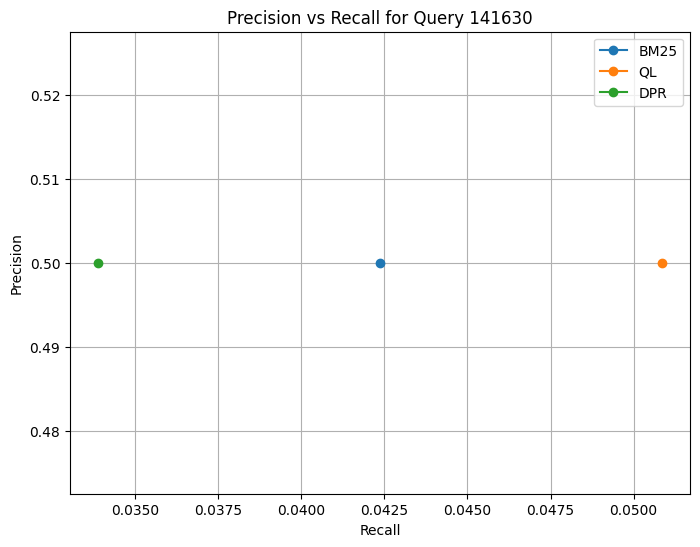

In [48]:
def calculate_precision_recall(query_info, total_relevant):
    retrieved = query_info["retrieved"]  # Documents retrieved by the model
    relevant_found = query_info["relFound"]  # Relevant documents retrieved

    precision = relevant_found / retrieved if retrieved > 0 else 0.0
    recall = relevant_found / total_relevant if total_relevant > 0 else 0.0
    return precision, recall

def get_total_relevant_documents(query_id, qrels_file):
    """Helper function to get total relevant documents from qrels file."""
    total_relevant = 0
    with open(qrels_file, 'r') as f:
        for line in f:
            q_id, _, doc_id, relevance = line.strip().split()
            if q_id == query_id and int(relevance) > 0:
                total_relevant += 1
    return total_relevant

def get_precision_recall(query_id, query_info, qrels_file):
    # Get the total relevant documents for the query from the qrels file
    total_relevant = get_total_relevant_documents(query_id, qrels_file)

    # Get precision and recall for BM25, QL, and DPR
    bm25_precision, bm25_recall = calculate_precision_recall(query_info["bm25"], total_relevant)
    ql_precision, ql_recall = calculate_precision_recall(query_info["ql"], total_relevant)
    dpr_precision, dpr_recall = calculate_precision_recall(query_info["dpr"], total_relevant)

    return {
        'BM25': (bm25_precision, bm25_recall),
        'QL': (ql_precision, ql_recall),
        'DPR': (dpr_precision, dpr_recall)
    }
import matplotlib.pyplot as plt

def plot_precision_recall(precision_recall_data):
    models = list(precision_recall_data.keys())
    plt.figure(figsize=(8, 6))

    for model in models:
        precision, recall = precision_recall_data[model]  # Directly assign precision and recall
        plt.plot([recall], [precision], label=model, marker='o')  # Plot as single points

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall for Query 141630')
    plt.legend()
    plt.grid(True)
    plt.show()
query_info = {
    "bm25": {"retrieved": 10, "relFound": 5},
    "ql": {"retrieved": 12, "relFound": 6},
    "dpr": {"retrieved": 8, "relFound": 4}
}

# Get precision and recall data for query 141630
precision_recall_data = get_precision_recall('141630', query_info, qrels_file)

# Plot the graph
plot_precision_recall(precision_recall_data)

# 5. Misc & Grading

**WARNING: Points breakdown may shift with a later version. This gives you an idea of what we are expecting to do.**

Your P2 submission is graded out of 100 points, allocated as follows:
* 75 points for the code (these are autograded)
  * 6 points: 3 points each for correctly calculating `numRel` and `relFound` on all six run files
  * 24 points: 6 points each for correctly calculating `RR`, `P@13`, `R@13`, and `F1@13` on all six run files
  * 45 points: 15 points each for correctly calculating `NDCG@23`, `AP`, and `BPREF` on all six run files
  * Up to 6 points extra credit for P@29R and P@R on all six run files

* 25 points for the analysis questions (these are graded manually):
  * 10 points for correctness of generated table (4.1)
  * 2 points for interpretation of generated table (4.2)
  * 3 points for discussion of MAP (4.3)
  * 10 points for correctness of recall/precision graph (4.4)
  * Up to 4 points for extra credit interpolation graph (4.5)

Note that we expect that you will upload your submission in the correct format (notebook and PDF), that the code in the notebook will run, and that the code will successfully process provided trecrun files, possibly including some you do not have access to.